**Essential Python packages:**

Below essential Python packages required for this notebook. run commands if these libraries are not already installed.

In [56]:
#!pip install tensorflow
#!pip install xgboost
#!pip install holidays
#!pip install scikeras
#!pip install pandas
#!pip install numpty
#!pip install seaborn
#!pip install statsmodels
#!pip install prophet

# Required Libraries

In [1]:
import warnings 
import holidays
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from prophet import Prophet

plt.style.use('ggplot')

from xgboost import XGBRegressor
from IPython.display import display
from matplotlib.pyplot import figure
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from math import sqrt

warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
# Load the first dataset

df_forecast = pd.read_csv(
    r"C:\Users\joshu\Desktop\forecastdemand_nsw.csv", 
    usecols=["FORECASTDEMAND", "DATETIME"]
)

# Load the second dataset
df_temp = pd.read_csv(
    r"C:\Users\joshu\Desktop\temperature_nsw.csv", 
    usecols=["TEMPERATURE", "DATETIME"]
)

# Load the third dataset
df_demand = pd.read_csv(
    r"C:\Users\joshu\Desktop\totaldemand_nsw.csv", 
    usecols=["TOTALDEMAND", "DATETIME"]
)


# Data Cleaning and Processing

In [3]:
# Check Nulls
print(df_forecast.isna().sum())
print(df_temp.isna().sum())
print(df_demand.isna().sum())

FORECASTDEMAND    0
DATETIME          0
dtype: int64
DATETIME       0
TEMPERATURE    0
dtype: int64
DATETIME       0
TOTALDEMAND    0
dtype: int64


In [4]:
# Remove spaces from DATETIME columns
df_forecast["DATETIME"] = df_forecast["DATETIME"].astype(str).str.strip()
df_temp["DATETIME"] = df_temp["DATETIME"].astype(str).str.strip()
df_demand["DATETIME"] = df_demand["DATETIME"].astype(str).str.strip()

# Aggregate FORECASTDEMAND by DATETIME using the MEAN
df_forecast = df_forecast.groupby("DATETIME")["FORECASTDEMAND"].agg(
    FORECASTING="mean"
).reset_index()

# Define the correct DATETIME format
datetime_format = "%d/%m/%Y %H:%M"
# Convert 'DATETIME' column with explicit format
df_forecast["DATETIME"] = pd.to_datetime(df_forecast["DATETIME"], errors="coerce", infer_datetime_format=True)
df_temp["DATETIME"] = pd.to_datetime(df_temp["DATETIME"], format=datetime_format, errors="coerce")
df_demand["DATETIME"] = pd.to_datetime(df_demand["DATETIME"], format=datetime_format, errors="coerce")

df_forecast.set_index('DATETIME', inplace=True)
df_temp.set_index('DATETIME', inplace=True)
df_demand.set_index('DATETIME', inplace=True)

In [5]:
# Check duplicates
print("Duplicate timestamps in df_forecast:", df_forecast.index.duplicated().sum())
print("Duplicate timestamps in df_temp:", df_temp.index.duplicated().sum())
print("Duplicate timestamps in df_demand:", df_demand.index.duplicated().sum())

Duplicate timestamps in df_forecast: 0
Duplicate timestamps in df_temp: 13
Duplicate timestamps in df_demand: 0


In [6]:
# Keep the first and drop the rest
df_forecast = df_forecast[~df_forecast.index.duplicated(keep='first')]
df_temp = df_temp[~df_temp.index.duplicated(keep='first')]
df_demand = df_demand[~df_demand.index.duplicated(keep='first')]

# Check duplicates again
print("Duplicate timestamps in df_forecast:", df_forecast.index.duplicated().sum())
print("Duplicate timestamps in df_temp:", df_temp.index.duplicated().sum())
print("Duplicate timestamps in df_demand:", df_demand.index.duplicated().sum())

Duplicate timestamps in df_forecast: 0
Duplicate timestamps in df_temp: 0
Duplicate timestamps in df_demand: 0


**During preprocessing, I identified a 30-minute gap in the temperature dataset. This missing interval was visually inspected, and I handled it in the following step by filling the gap**

In [7]:
# Generate complete 30-minute range from min to max time
expected_index = pd.date_range(
    start=df_temp.index.min(),
    end=df_temp.index.max(),
    freq='30T'
)

# Reindex to find missing rows
df_temp_reindexed = df_temp.reindex(expected_index)

# Find missing timestamps
missing_timestamps = df_temp_reindexed[df_temp_reindexed.isnull().any(axis=1)].index

# Show how many and preview them
print(f"Missing 30-min intervals Temp Table: {len(missing_timestamps)}")
print(missing_timestamps[:10])  # Show first 10 missing rows

# Generate complete 30-minute range from min to max time
expected_index = pd.date_range(
    start=df_demand.index.min(),
    end=df_demand.index.max(),
    freq='30T'
)

# Reindex to find missing rows
df_demand_reindexed = df_demand.reindex(expected_index)

# Find missing timestamps
missing_timestamps = df_demand_reindexed[df_demand_reindexed.isnull().any(axis=1)].index

# Show how many and preview them
print(f"Missing 30-min intervals Demand Table: {len(missing_timestamps)}")
print(missing_timestamps[:10])  # Show first 10 missing rows


Missing 30-min intervals Temp Table: 579
DatetimeIndex(['2010-01-10 04:00:00', '2010-01-11 17:00:00',
               '2010-01-14 13:30:00', '2010-01-15 10:30:00',
               '2010-01-16 10:30:00', '2010-01-19 00:30:00',
               '2010-01-19 10:30:00', '2010-01-20 15:30:00',
               '2010-01-21 18:00:00', '2010-01-23 08:30:00'],
              dtype='datetime64[ns]', freq=None)
Missing 30-min intervals Demand Table: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='30min')


**Filling Missing data in Temperature Dataframe**

In [8]:
df_temp_reindexed['TEMPERATURE'] = df_temp_reindexed['TEMPERATURE'].fillna(method='ffill')

# Rename index back to 'DATETIME' for clarity
df_temp_reindexed.index.name = 'DATETIME'

# Final updated temperature dataset
df_temp = df_temp_reindexed

print(f"\nFinal shape: {df_temp.shape}")
print(f"Remaining missing values:\n{df_temp.isna().sum()}")


Final shape: (196513, 1)
Remaining missing values:
TEMPERATURE    0
dtype: int64


In [9]:
# Merge all datasets into a single DataFrame based on DATETIME
df = pd.merge(pd.merge(df_demand, df_forecast, on='DATETIME', how='inner'), df_temp, on='DATETIME', how='inner')

**Year 2021 was excluded because has data from Jan to Mar.**

In [10]:
df_filtered = df[(df.index.minute == 0) & (~df.index.year.isin([2021]))]

In [11]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96432 entries, 2010-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TOTALDEMAND  96432 non-null  float64
 1   FORECASTING  96432 non-null  float64
 2   TEMPERATURE  96432 non-null  float64
dtypes: float64(3)
memory usage: 2.9 MB


# Feature Engineering

In [12]:
df_filtered['YEAR'] = df_filtered.index.year
df_filtered['MONTH'] = df_filtered.index.month

# Calculate monthly average demand per year
monthly_avg = df_filtered.groupby(['YEAR', 'MONTH'])['TOTALDEMAND'].mean().reset_index()

# Find min and max avg month for each year
summary = monthly_avg.groupby('YEAR').apply(
    lambda x: pd.Series({
        'Min Month': x.loc[x['TOTALDEMAND'].idxmin(), 'MONTH'],
        'Min Demand': x['TOTALDEMAND'].min(),
        'Max Month': x.loc[x['TOTALDEMAND'].idxmax(), 'MONTH'],
        'Max Demand': x['TOTALDEMAND'].max()
    })
).reset_index()

# Convert numeric month to month names for better readability
summary['Min Month'] = summary['Min Month'].apply(lambda m: pd.to_datetime(f'2023-{int(m):02d}-01').strftime('%B'))
summary['Max Month'] = summary['Max Month'].apply(lambda m: pd.to_datetime(f'2023-{int(m):02d}-01').strftime('%B'))

display(summary)


,YEAR,Min Month,Min Demand,Max Month,Max Demand
0,2010,October,8200.708011,July,9686.577567
1,2011,December,7816.294906,July,9557.105417
2,2012,October,7570.463978,June,9146.568153
3,2013,October,7511.467164,July,8612.534987
4,2014,October,7433.472755,July,8668.032661
5,2015,October,7441.692473,July,9004.627204
6,2016,October,7197.173078,July,8636.156586
7,2017,October,7300.351922,July,8745.889825
8,2018,October,7410.826747,June,8747.172944
9,2019,October,7202.675444,January,8983.954073


In [13]:
# Create new features
df_filtered['DATE'] = df_filtered.index.date
df_filtered['YEAR'] = df_filtered.index.year
df_filtered['MONTH'] = df_filtered.index.month
df_filtered['DAYOFWEEK'] = df_filtered.index.dayofweek
df_filtered['HOUR'] = df_filtered.index.hour
df_filtered['DAYOFWEEK'] = df_filtered.index.dayofweek
df_filtered['DAY'] = df_filtered.index.dayofyear

df_filtered['IS_WEEKEND'] = df_filtered['DAYOFWEEK'].isin([5, 6]).astype(int)

# Peak hours by season
df_filtered['SEASON'] = df_filtered.apply(
    lambda row: 'Summer' if (
        (row['MONTH'] == 11 and row['DATE'].day >= 1) or
        (row['MONTH'] == 12) or
        (row['MONTH'] == 1) or
        (row['MONTH'] == 2) or
        (row['MONTH'] == 3 and row['DATE'].day <= 31)
    ) else (
        'Winter' if (
            (row['MONTH'] == 6 and row['DATE'].day >= 1) or
            (row['MONTH'] == 7) or
            (row['MONTH'] == 8 and row['DATE'].day <= 31)
        ) else 'Other'
    ),
    axis=1
)

#----

df_filtered['IS_SEASONAL_PEAK_HOUR'] = 0
df_filtered.loc[
    (df_filtered['SEASON'] == 'Summer') &
    (df_filtered['HOUR'].isin([14, 15, 16, 17, 18, 19, 20])) &
    (df_filtered['IS_WEEKEND'] == 0),
    'IS_SEASONAL_PEAK_HOUR'
] = 1

df_filtered.loc[
    (df_filtered['SEASON'] == 'Winter') &
    (df_filtered['HOUR'].isin([7, 8, 17, 18, 19, 20, 21])) &
    (df_filtered['IS_WEEKEND'] == 0),
    'IS_SEASONAL_PEAK_HOUR'
] = 1

# Create IS_SEASONAL_OFFPEAK_HOUR (Weekdays only)
df_filtered['IS_SEASONAL_OFFPEAK_HOUR'] = 0
df_filtered.loc[
    (df_filtered['SEASON'] == 'Summer') &
    (df_filtered['HOUR'].isin([0, 1, 2, 3, 4, 5, 6])) &
    (df_filtered['IS_WEEKEND'] == 0),
    'IS_SEASONAL_OFFPEAK_HOUR'
] = 1

df_filtered.loc[
    (df_filtered['SEASON'] == 'Winter') &
    (df_filtered['HOUR'].isin([0, 1, 2, 3, 4, 5])) &
    (df_filtered['IS_WEEKEND'] == 0),
    'IS_SEASONAL_OFFPEAK_HOUR'
] = 1

# Public Holidays periods
nsw_holidays = holidays.Australia(prov='NSW', years=range(2010, 2021))
holiday_dates = [date for date in nsw_holidays.keys()]
df_filtered['IS_PUBLIC_HOLIDAY'] = df_filtered['DATE'].isin(holiday_dates).astype(int)

# New Year period
new_year_ranges = []
for year in range(2010, 2021):
    new_year_ranges.extend([(f"{year-1}-12-31", f"{year}-01-02")])

new_year_dates = []
for start, end in new_year_ranges:
    new_year_dates.extend(pd.date_range(start=start, end=end))
    
new_year_dates = [d.date() for d in new_year_dates]
df_filtered['IS_NEW_YEAR_PERIOD'] = df_filtered['DATE'].isin(new_year_dates).astype(int)

# School Term periods
school_term_ranges = []
for year in range(2010, 2021):
    school_term_ranges.extend([
        (f'{year}-02-01', f'{year}-04-09'),  # Term 1
        (f'{year}-04-26', f'{year}-07-04'),  # Term 2
        (f'{year}-07-21', f'{year}-09-27'),  # Term 3
        (f'{year}-10-10', f'{year}-12-19')   # Term 4
    ])

school_term_dates = []
for start, end in school_term_ranges:
    school_term_dates.extend(pd.date_range(start=start, end=end))

school_term_dates = [d.date() for d in school_term_dates]

df_filtered['IS_SCHOOL_BREAK'] =(~df_filtered['DATE'].isin(school_term_dates)).astype(int)

df_filtered['DAY_TYPE'] = 'Regular_Day'
#df_filtered.loc[df_filtered['IS_PUBLIC_HOLIDAY'] == 1, 'DAY_TYPE'] = 'IS_PUBLIC_HOLIDAY'
df_filtered.loc[
    (df_filtered[['IS_PUBLIC_HOLIDAY', 'IS_NEW_YEAR_PERIOD']].sum(axis=1) > 0) &
    (df_filtered['DAY_TYPE'] == 'Regular_Day'),
    'DAY_TYPE'
] = 'IS_PUBLIC_HOLIDAY'
df_filtered.loc[(df_filtered['IS_NEW_YEAR_PERIOD'] == 1) & (df_filtered['DAY_TYPE'] == 'Regular_Day'), 'DAY_TYPE'] = 'IS_NEW_YEAR_PERIOD'
df_filtered.loc[(df_filtered['IS_SCHOOL_BREAK'] == 1) & (df_filtered['DAY_TYPE'] == 'Regular_Day'), 'DAY_TYPE'] = 'IS_SCHOOL_BREAK'

def get_time_block(hour):
    if 5 <= hour <= 11:  
        return 0 # Morning
    elif 12 <= hour <= 16: 
        return 1 # Afternoon
    elif 17 <= hour <= 21: 
        return 2 # Evening
    else:                  
        return 3 # Late-night

# Time block
df_filtered["TIME_BLOCK"] = df_filtered["HOUR"].apply(get_time_block)

df_filtered['IS_COMFORT_ZONE'] = ((df_filtered['TEMPERATURE'] >= 17) & (df_filtered['TEMPERATURE'] <= 24)).astype(int)

# Eliminate unnecessary features
df_filtered = df_filtered.drop(columns=(["DAYOFWEEK", "IS_SCHOOL_BREAK", "IS_NEW_YEAR_PERIOD" \
                                         ,"IS_PUBLIC_HOLIDAY"]))


In [14]:
# Step 1: Filter 2015 data
df_2015 = df_filtered.copy()

# Step 2: Round temperature
df_2015['TEMP_ROUNDED'] = df_2015['TEMPERATURE'].round(0)

# Step 3: Group by temperature and calculate average demand
temp_demand_table = df_2015.groupby('TEMP_ROUNDED')['TOTALDEMAND'].mean().reset_index()
temp_demand_table.columns = ['Temperature (°C)', 'Average Demand (MW)']

# Step 4: Sort by temperature
temp_demand_table = temp_demand_table.sort_values('Temperature (°C)').reset_index(drop=True)

# Step 5: Calculate percentage change from previous row
temp_demand_table['% Change from Previous Temp'] = temp_demand_table['Average Demand (MW)'].pct_change() * 100
temp_demand_table['% Change from Previous Temp'] = temp_demand_table['% Change from Previous Temp'].round(2)

# Optional: Replace NaN in the first row with '-'
temp_demand_table['% Change from Previous Temp'] = temp_demand_table['% Change from Previous Temp'].fillna('-')

display(temp_demand_table.head(5))
display(temp_demand_table.tail(5))


,Temperature (°C),Average Demand (MW),% Change from Previous Temp
0,-1.0,8515.783333,-
1,0.0,8338.200833,-2.09
2,1.0,8441.200000,1.24
3,2.0,7751.571570,-8.17
4,3.0,7769.200480,0.23


,Temperature (°C),Average Demand (MW),% Change from Previous Temp
42,41.0,11761.998333,-5.34
43,42.0,11477.237500,-2.42
44,43.0,13348.420000,16.3
45,44.0,11814.163333,-11.49
46,45.0,11259.310000,-4.7


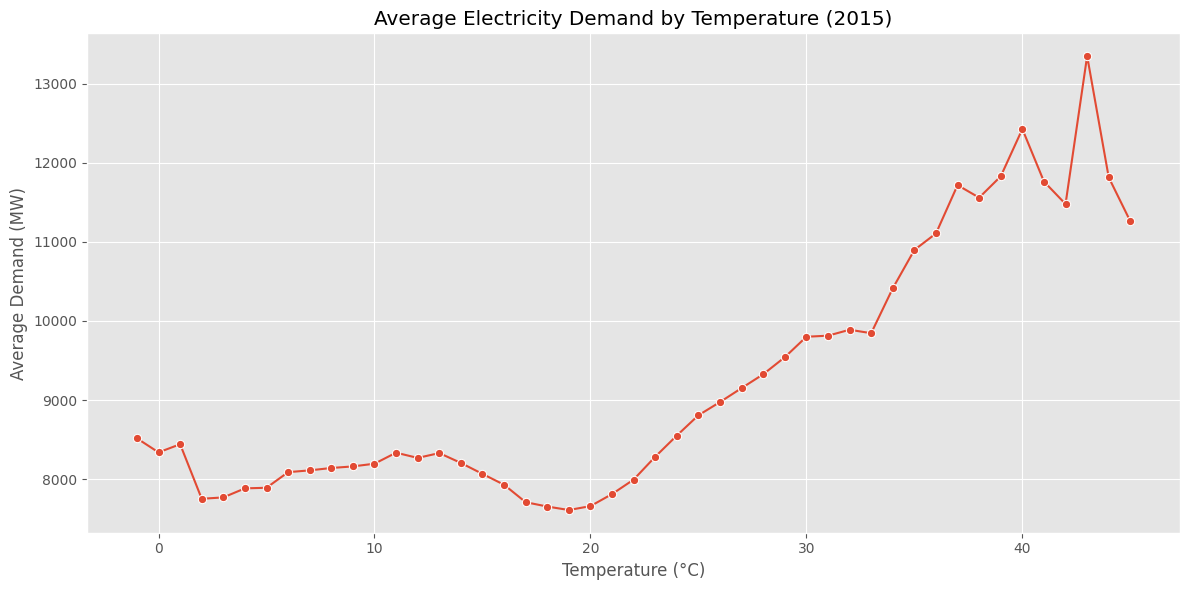

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=temp_demand_table, x='Temperature (°C)', y='Average Demand (MW)', marker='o')
plt.title('Average Electricity Demand by Temperature (2015)')
plt.ylabel('Average Demand (MW)')
plt.xlabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

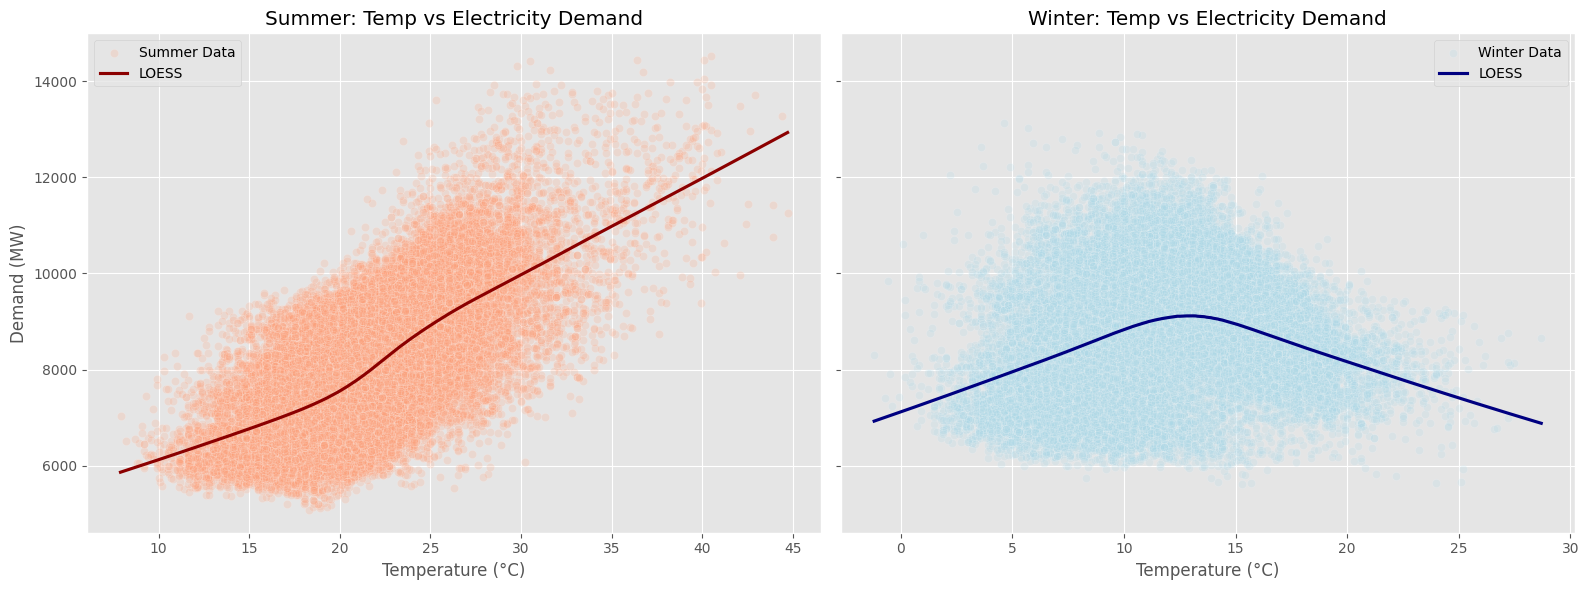

In [16]:
# Filter only Summer and Winter
summer_df = df_filtered[df_filtered['SEASON'] == 'Summer']
winter_df = df_filtered[df_filtered['SEASON'] == 'Winter']

# Set up plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Summer
sns.scatterplot(data=summer_df, x='TEMPERATURE', y='TOTALDEMAND', alpha=0.2, color='lightsalmon', ax=axes[0], label='Summer Data')
sns.regplot(data=summer_df, x='TEMPERATURE', y='TOTALDEMAND', lowess=True, scatter=False, color='darkred', ax=axes[0], label='LOESS')
axes[0].set_title('Summer: Temp vs Electricity Demand')
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Demand (MW)')
axes[0].legend()
axes[0].grid(True)

# Winter
sns.scatterplot(data=winter_df, x='TEMPERATURE', y='TOTALDEMAND', alpha=0.2, color='lightblue', ax=axes[1], label='Winter Data')
sns.regplot(data=winter_df, x='TEMPERATURE', y='TOTALDEMAND', lowess=True, scatter=False, color='navy', ax=axes[1], label='LOESS')
axes[1].set_title('Winter: Temp vs Electricity Demand')
axes[1].set_xlabel('Temperature (°C)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Visualisation

In [17]:
# Create Summary Table

df_filtered_valid = df_filtered[df_filtered['SEASON'].isin(['Summer', 'Winter', 'Other'])]

summary = (
    df_filtered_valid
    .groupby(['SEASON', 'DAY_TYPE'])
    .agg(
        AVG_ACTUAL_DEMAND=('TOTALDEMAND', 'mean'),
        AVG_FORECASTED_DEMAND=('FORECASTING', 'mean')
    )
    .reset_index()
)

# Forecast error = actual - forecast
summary['FORECAST_ERROR'] = np.abs(summary['AVG_ACTUAL_DEMAND'] - summary['AVG_FORECASTED_DEMAND'])
summary = summary.round(2)

display(summary)

,SEASON,DAY_TYPE,AVG_ACTUAL_DEMAND,AVG_FORECASTED_DEMAND,FORECAST_ERROR
0,Other,IS_PUBLIC_HOLIDAY,6933.53,6896.50,37.03
1,Other,IS_SCHOOL_BREAK,7589.31,7593.27,3.96
2,Other,Regular_Day,7831.79,7833.56,1.77
3,Summer,IS_PUBLIC_HOLIDAY,7280.23,7205.55,74.67
4,Summer,IS_SCHOOL_BREAK,8306.20,8270.55,35.66
5,Summer,Regular_Day,8021.57,8015.21,6.36
6,Winter,IS_PUBLIC_HOLIDAY,8247.46,8232.38,15.08
7,Winter,IS_SCHOOL_BREAK,8931.38,8957.36,25.98
8,Winter,Regular_Day,8703.00,8704.82,1.82


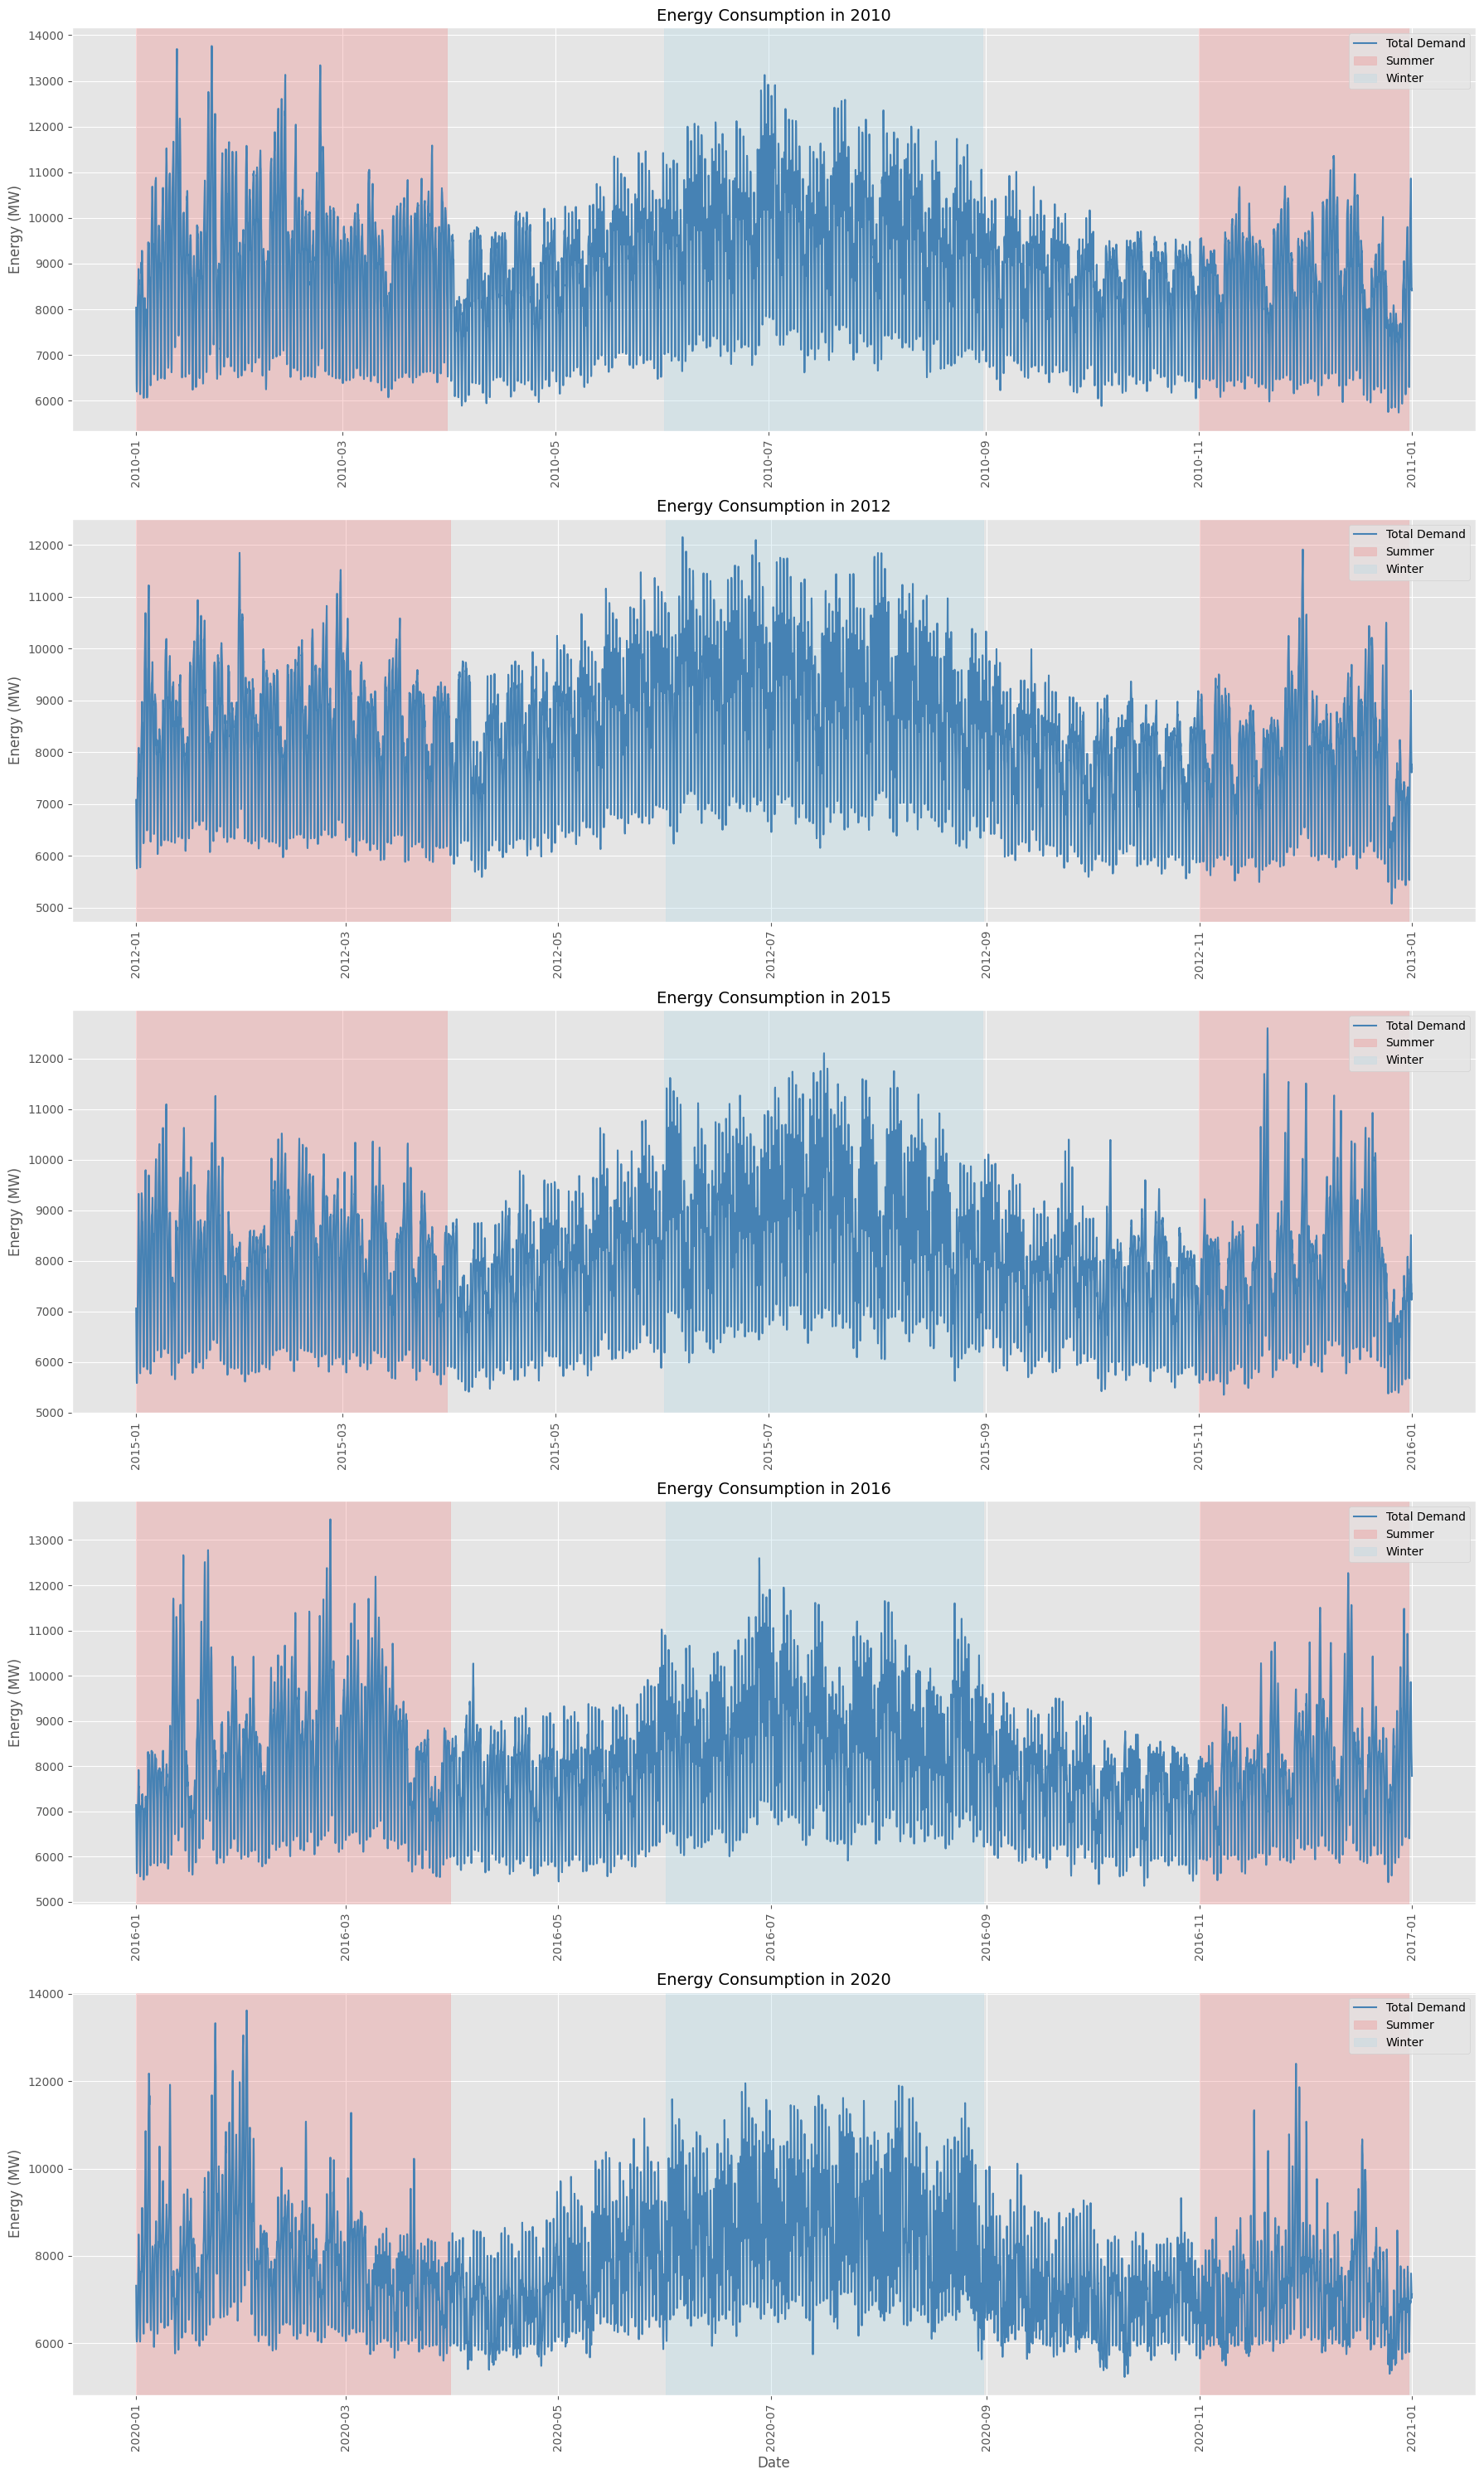

In [18]:
# Years to plot
years = [2010, 2012, 2015, 2016, 2020]

# Create figure and subplots
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(18, 30), sharex=False)

# Loop through each year and subplot
for i, year in enumerate(years):
    yearly_data = df_filtered[df_filtered["YEAR"] == year]
    x = yearly_data.index
    y = yearly_data["TOTALDEMAND"]

    # Plot energy consumption line
    axes[i].plot(x, y, color="#4682B4", linewidth=1.5, label="Total Demand")

    # Shade Summer (1 Nov (previous year) to 31 Mar (current year))
    start_summer_prev_p1 = pd.Timestamp(f"{year}-11-01")
    end_summer_p1 = pd.Timestamp(f"{year}-12-31") 
    axes[i].axvspan(start_summer_prev_p1, end_summer_p1, color='lightcoral', alpha=0.3, label='Summer')

    start_summer_prev_p2 = pd.Timestamp(f"{year}-01-01")
    end_summer_p2 = pd.Timestamp(f"{year}-03-31") 
    axes[i].axvspan(start_summer_prev_p2, end_summer_p2, color='lightcoral', alpha=0.3)

    # Shade Winter (1 Jun to 31 Aug)
    start_winter = pd.Timestamp(f"{year}-06-01") 
    end_winter = pd.Timestamp(f"{year}-08-31")
    axes[i].axvspan(start_winter, end_winter, color='lightblue', alpha=0.3, label='Winter')

    axes[i].set_title(f"Energy Consumption in {year}", fontsize=14)
    axes[i].set_ylabel("Energy (MW)")
    axes[i].grid(True)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].legend(loc="upper right")

axes[-1].set_xlabel("Date")

plt.tight_layout()
plt.show()

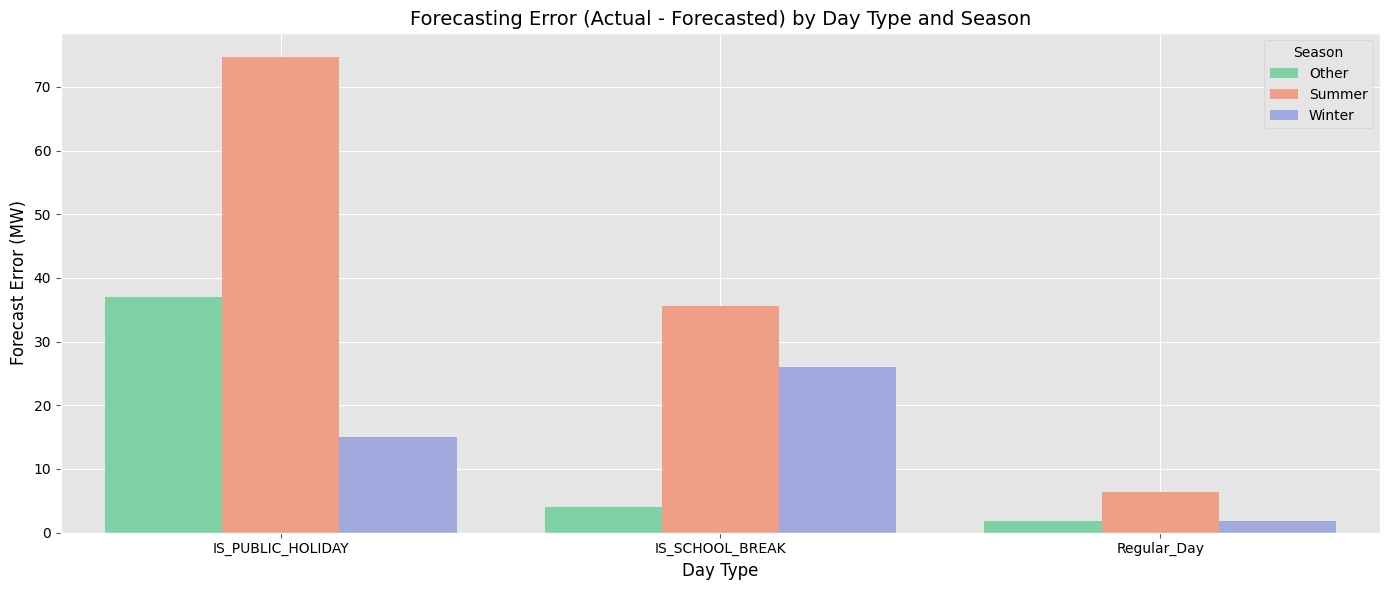

In [19]:

# Custom color palette for seasons
season_palette = {
    'Summer': '#FF9675',
    'Winter': '#95A3E9',
    'Other': '#72DDA1'
}

# Plot Forecast Error
plt.figure(figsize=(14, 6))
sns.barplot(
    data=summary,
    x='DAY_TYPE',
    y='FORECAST_ERROR',
    hue='SEASON',
    ci=None,
    palette=season_palette
)

plt.title("Forecasting Error (Actual - Forecasted) by Day Type and Season", fontsize=14)
plt.xlabel("Day Type", fontsize=12, color='black')
plt.ylabel("Forecast Error (MW)", fontsize=12, color='black')
plt.xticks(rotation=0)
plt.xticks(rotation=0, fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')
plt.legend(title="Season")
plt.grid(True)
plt.tight_layout()
plt.show()


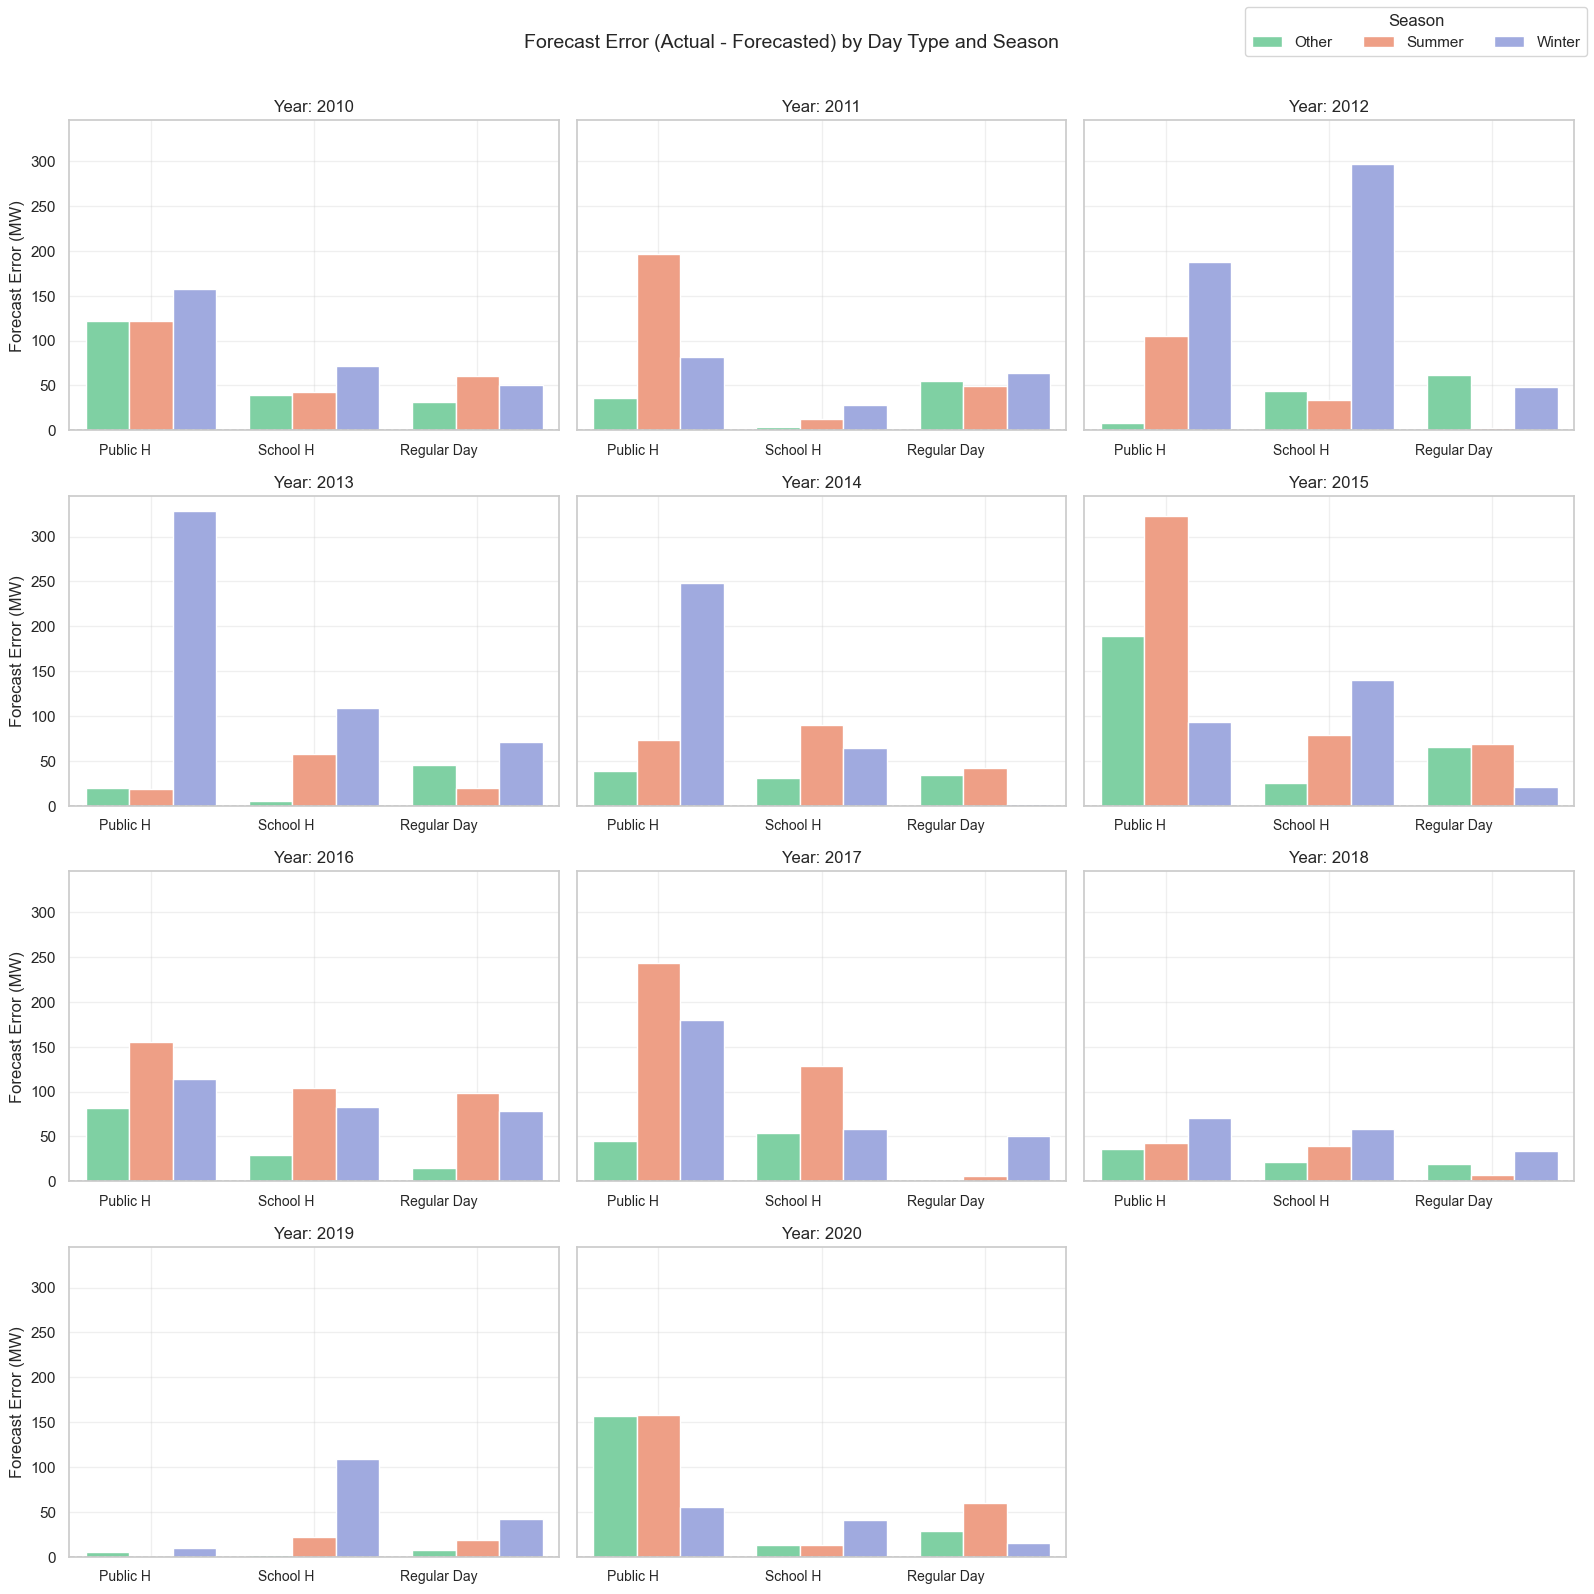

In [20]:
sns.set(style='whitegrid')

# Custom color palette for seasons
season_palette = {
    'Summer': '#FF9675',
    'Winter': '#95A3E9',
    'Other': '#72DDA1'
}

df_filtered_valid = df_filtered[df_filtered['SEASON'].isin(['Summer', 'Winter', 'Other'])]

summary_full_duration = (
    df_filtered_valid
    .groupby(['YEAR', 'SEASON', 'DAY_TYPE'])
    .agg(
        AVG_ACTUAL_DEMAND=('TOTALDEMAND', 'mean'),
        AVG_FORECASTED_DEMAND=('FORECASTING', 'mean')
    )
    .reset_index()
)

summary_full_duration['FORECAST_ERROR'] = np.abs(summary_full_duration['AVG_ACTUAL_DEMAND'] - summary_full_duration['AVG_FORECASTED_DEMAND'])
summary_full_duration = summary_full_duration.round(2)

# Mapping long day types to short labels
day_type_map = {
    'IS_PUBLIC_HOLIDAY': 'Public H',
    'IS_NEW_YEAR_PERIOD': 'NewYear H',
    'IS_SCHOOL_BREAK': 'School H',
    'Regular_Day': 'Regular Day'
}

years = sorted(summary_full_duration['YEAR'].unique())
n_years = len(years)

# Layout: 3 plots per row
n_cols = 3
n_rows = (n_years + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows), sharey=True)
axes = axes.flatten()

# Plot each year's data
for i, year in enumerate(years):
    ax = axes[i]
    year_data = summary_full_duration[summary_full_duration['YEAR'] == year]
    
    sns.barplot(
        data=year_data,
        x='DAY_TYPE',
        y='FORECAST_ERROR',
        hue='SEASON',
        ci=None,
        palette=season_palette,
        ax=ax
    )
    
    ax.set_title(f"Year: {year}")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel("")
    ax.set_ylabel("Forecast Error (MW)")
    new_labels = [day_type_map.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()]
    ax.set_xticklabels(new_labels, ha='right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend().remove()

# Hide unused axes if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# legend for plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Season", loc='upper right', ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Forecast Error (Actual - Forecasted) by Day Type and Season", fontsize=14)
plt.show()



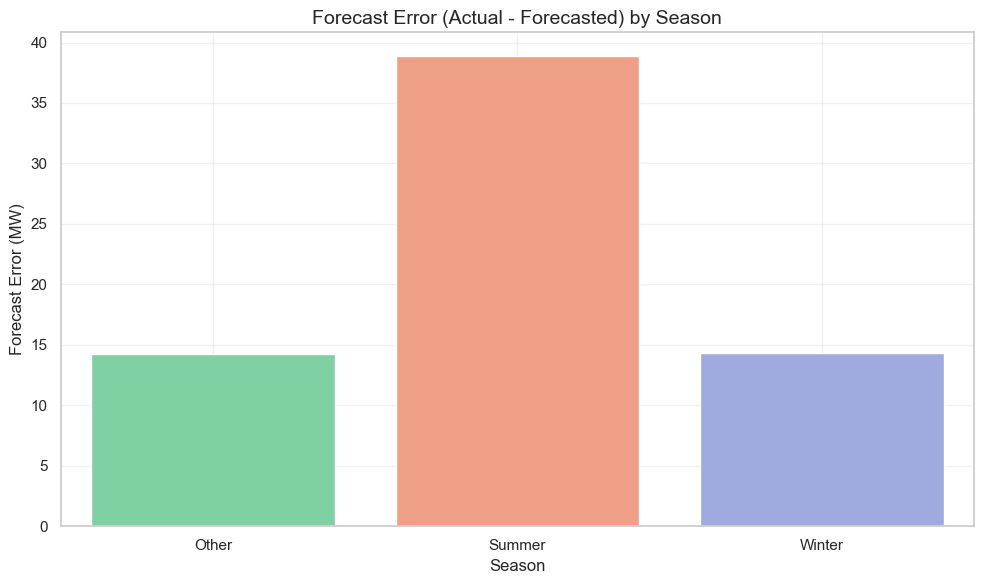

In [21]:
# Plot Forecast Error by Season only
plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary,
    x='SEASON',
    y='FORECAST_ERROR',
    ci=None,
    palette=season_palette
)


# Titles and labels
plt.title("Forecast Error (Actual - Forecasted) by Season", fontsize=14)
plt.xlabel("Season")
plt.ylabel("Forecast Error (MW)")
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


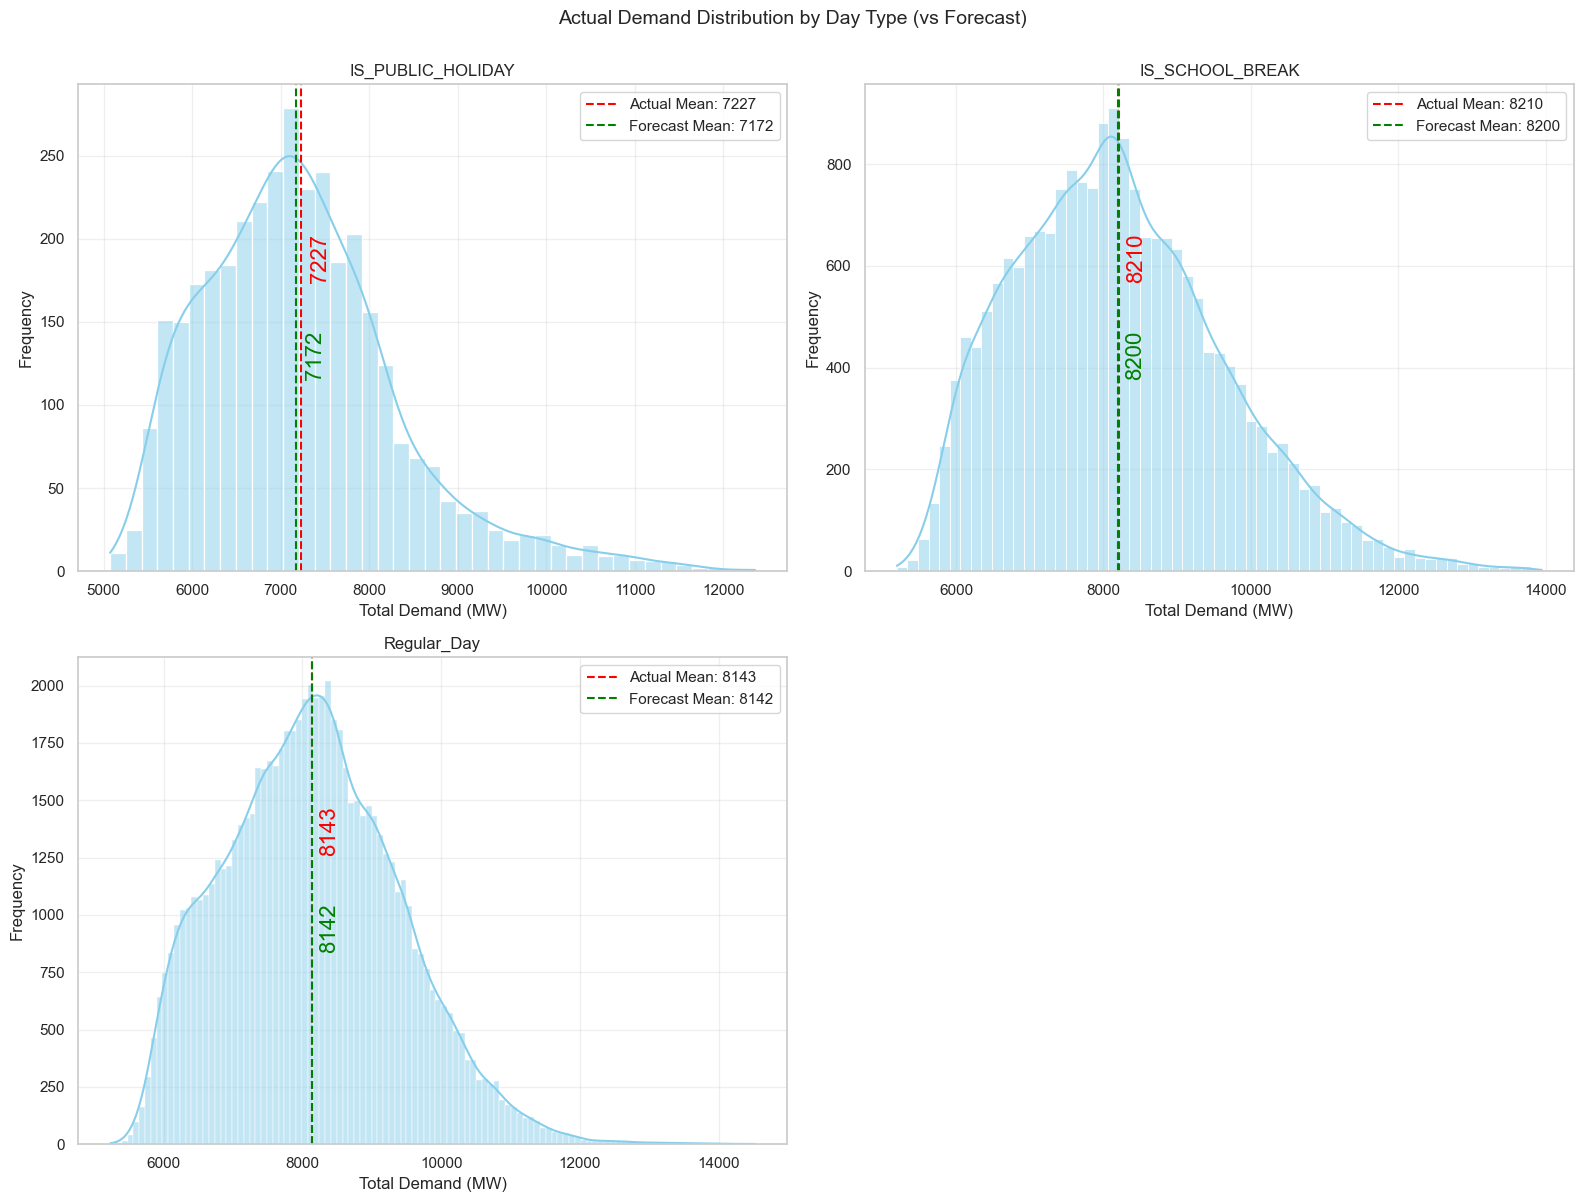

In [22]:
sns.set(style='whitegrid')
day_types = df_filtered['DAY_TYPE'].unique()
num_types = len(day_types)

# Layout: 2 plots per row
n_cols = 2
n_rows = int(np.ceil(num_types / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows), sharey=False)
axes = axes.flatten()

for i, day_type in enumerate(day_types):
    ax = axes[i]
    subset = df_filtered[df_filtered['DAY_TYPE'] == day_type]
    
    # Plot histogram
    sns.histplot(
        data=subset,
        x="TOTALDEMAND",
        kde=True,
        ax=ax,
        color='skyblue'
    )
    
    # Mean for actual demand
    mean_actual = subset['TOTALDEMAND'].mean()
    ax.axvline(mean_actual, color='red', linestyle='--', linewidth=1.5, label=f'Actual Mean: {mean_actual:.0f}')
    ax.text(mean_actual + 100, ax.get_ylim()[1]*0.6, f'{mean_actual:.0f}', rotation=90, color='red', fontsize=16)

    # Mean for forecasted demand
    mean_forecast = subset['FORECASTING'].mean()
    ax.axvline(mean_forecast, color='green', linestyle='--', linewidth=1.5, label=f'Forecast Mean: {mean_forecast:.0f}')
    ax.text(mean_forecast + 100, ax.get_ylim()[1]*0.4, f'{mean_forecast:.0f}', rotation=90, color='green', fontsize=16)

    ax.set_title(f"{day_type}")
    ax.set_xlabel("Total Demand (MW)")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
    ax.legend()

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Actual Demand Distribution by Day Type (vs Forecast)", fontsize=14, y=1)
plt.tight_layout()
plt.show()


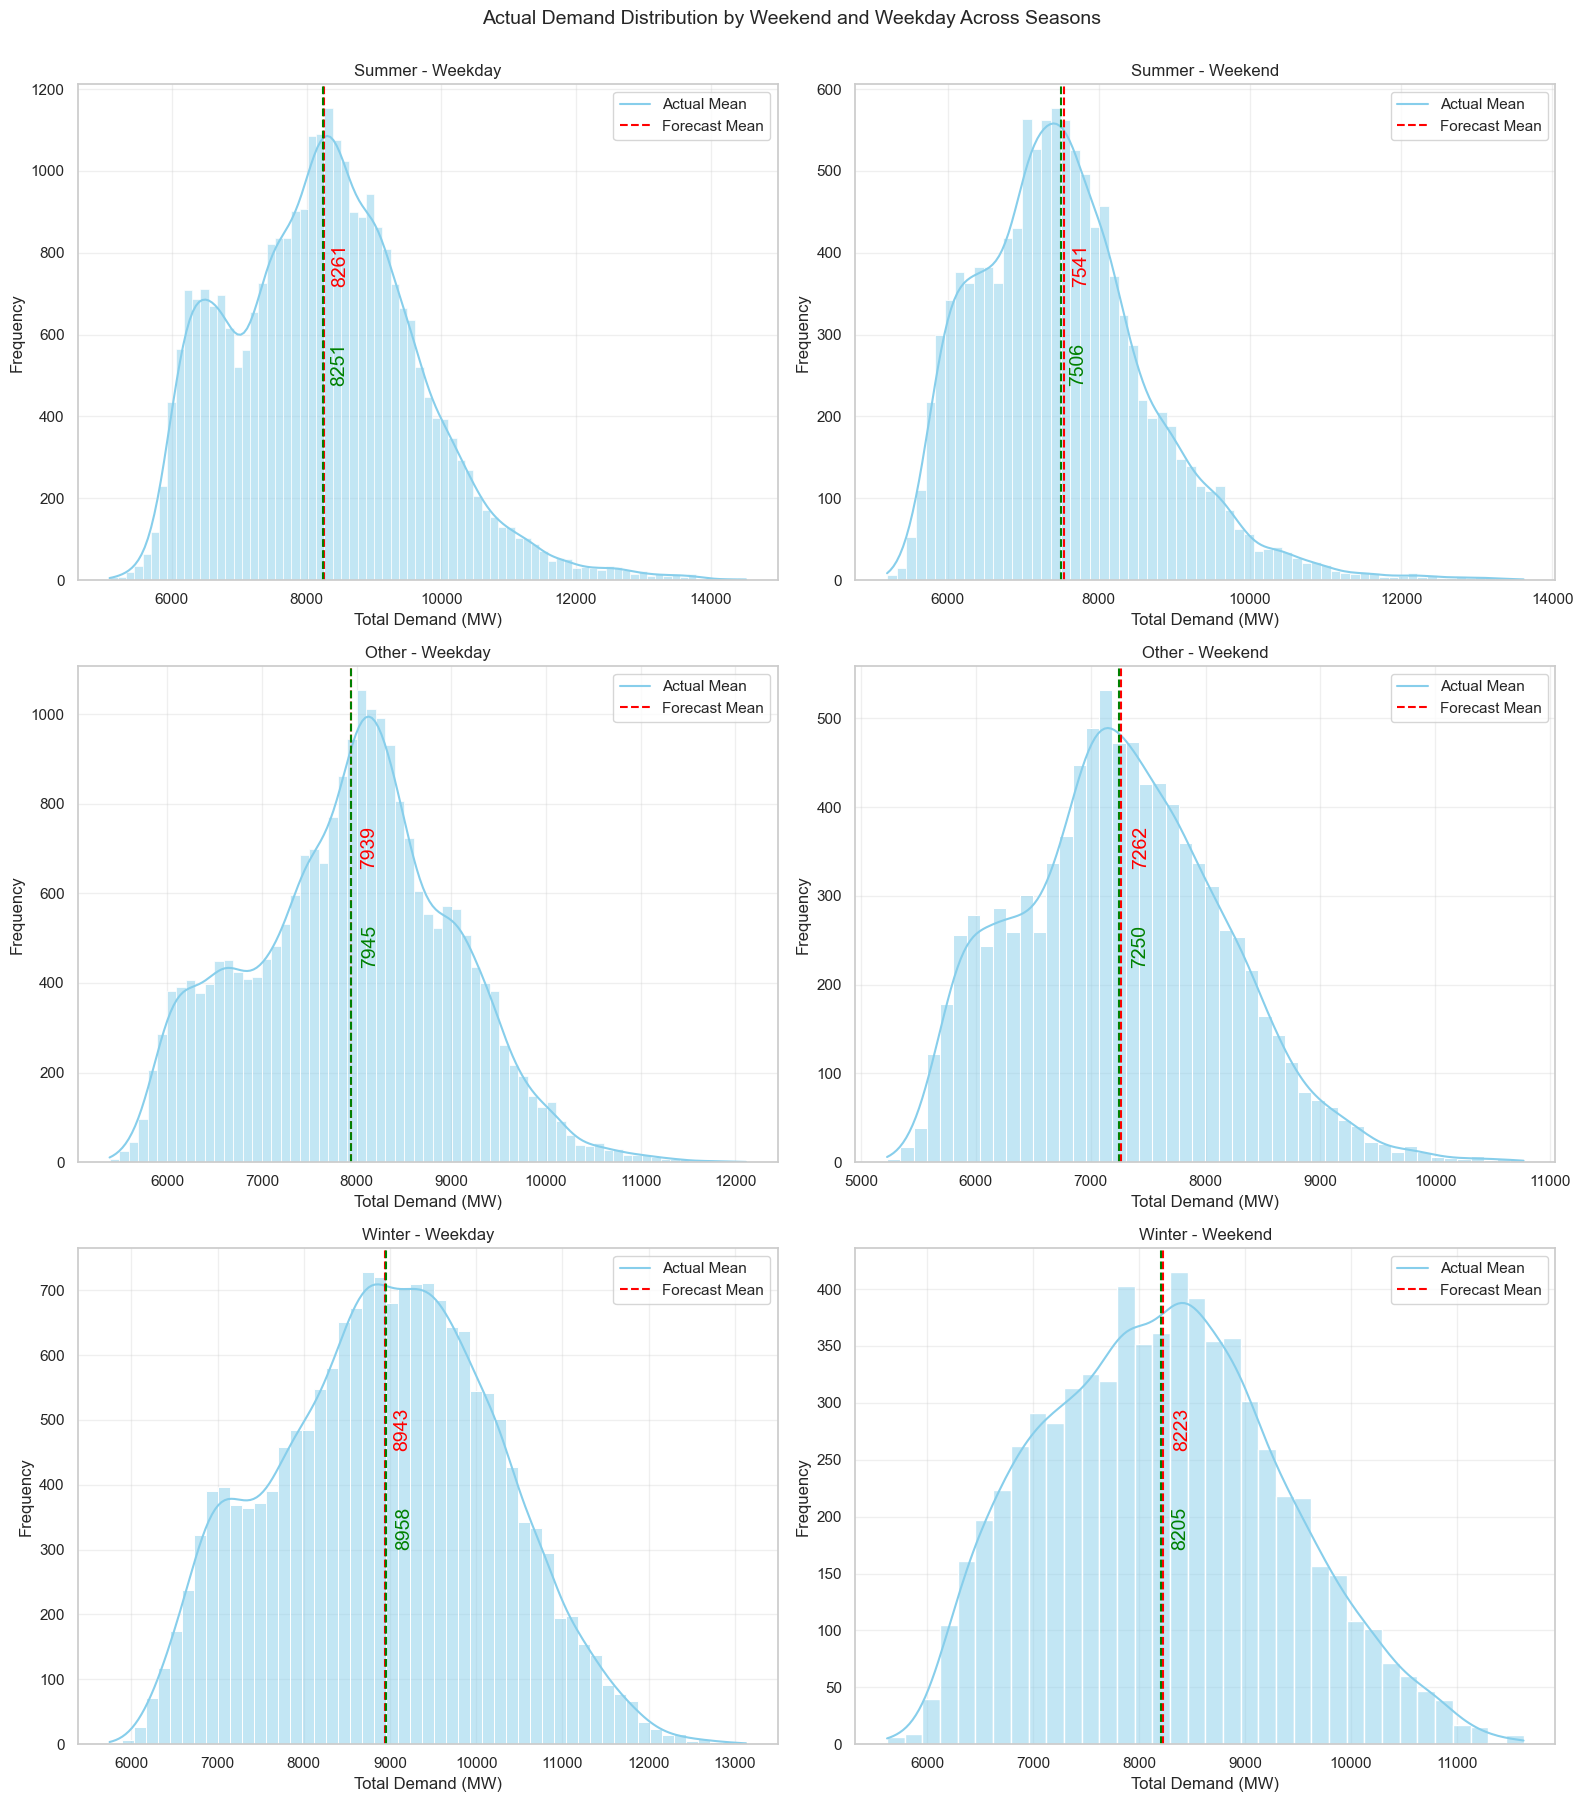

In [23]:
sns.set(style='whitegrid')

seasons = df_filtered['SEASON'].unique()
n_seasons = len(seasons)

# Layout: 2 plots per row
n_cols = 2
n_rows = n_seasons

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows), sharey=False)
axes = axes.reshape(n_rows, n_cols)

for i, season in enumerate(seasons):
    for j, is_weekend in enumerate([0, 1]):
        ax = axes[i][j]
        label = "Weekday" if is_weekend == 0 else "Weekend"
        
        subset = df_filtered[(df_filtered['SEASON'] == season) & (df_filtered['IS_WEEKEND'] == is_weekend)]

        # Plot histogram
        sns.histplot(
            data=subset,
            x="TOTALDEMAND",
            kde=True,
            ax=ax,
            color='skyblue'
        )

        # Mean for actual demand
        mean_actual = subset['TOTALDEMAND'].mean()
        ax.axvline(mean_actual, color='red', linestyle='--', linewidth=1.5, label=f'Actual Mean: {mean_actual:.0f}')
        ax.text(mean_actual + 100, ax.get_ylim()[1]*0.6, f'{mean_actual:.0f}', rotation=90, color='red', fontsize=14)
        
        # Mean for forecasted demand
        mean_forecast = subset['FORECASTING'].mean()
        ax.axvline(mean_forecast, color='green', linestyle='--', linewidth=1.5, label=f'Forecast Mean: {mean_forecast:.0f}')
        ax.text(mean_forecast + 100, ax.get_ylim()[1]*0.4, f'{mean_forecast:.0f}', rotation=90, color='green', fontsize=14)


        ax.set_title(f"{season} - {label}")
        ax.set_xlabel("Total Demand (MW)")
        ax.set_ylabel("Frequency")
        ax.grid(True, alpha=0.3)
        ax.legend(['Actual Mean', 'Forecast Mean'])

plt.suptitle("Actual Demand Distribution by Weekend and Weekday Across Seasons", fontsize=14, y=1)
plt.tight_layout()
plt.show()


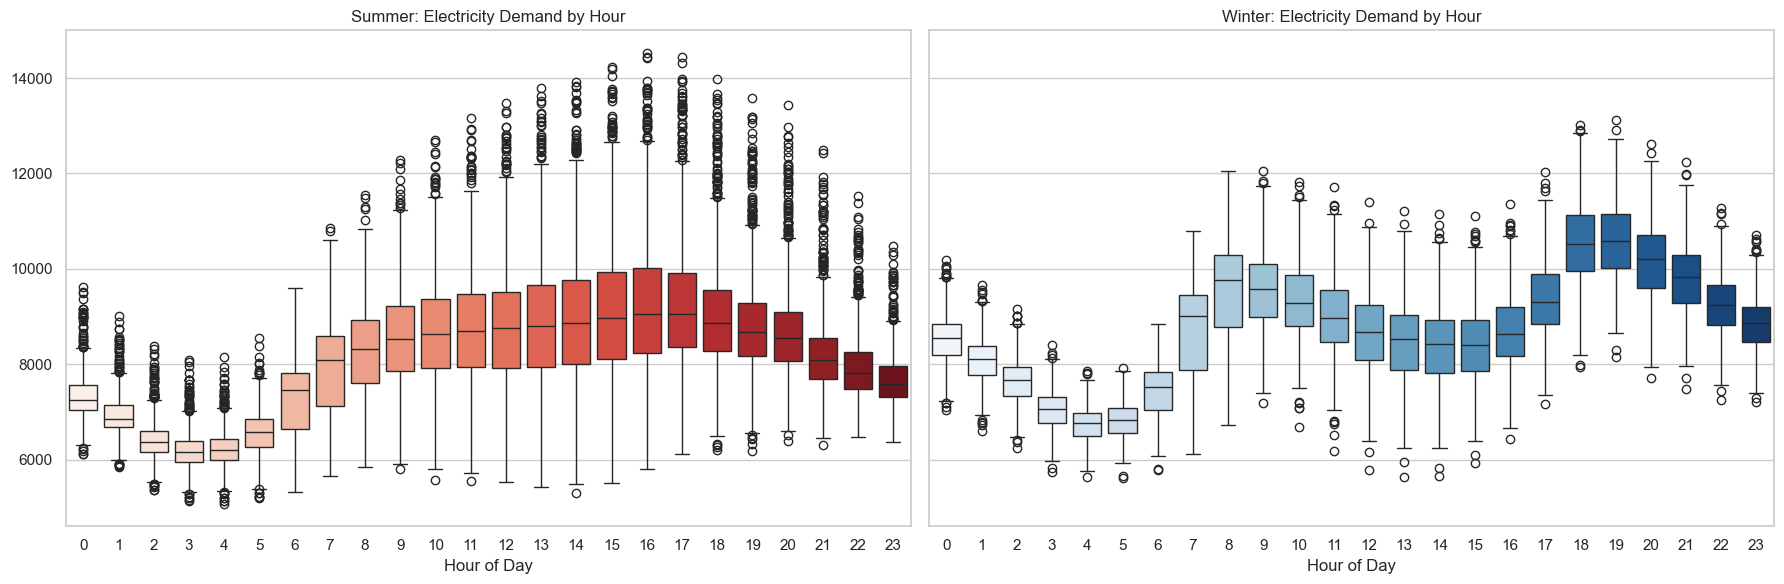

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

summer_data = df_filtered[df_filtered['SEASON'] == 'Summer']
winter_data = df_filtered[df_filtered['SEASON'] == 'Winter']

# Summer plot
sns.boxplot(data=summer_data, x='HOUR', y='TOTALDEMAND', ax=axes[0], palette='Reds')
axes[0].set_title('Summer: Electricity Demand by Hour')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('')

# Winter plot
sns.boxplot(data=winter_data, x='HOUR', y='TOTALDEMAND', ax=axes[1], palette='Blues')
axes[1].set_title('Winter: Electricity Demand by Hour')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Total Demand (MW)')

plt.tight_layout()
plt.show()


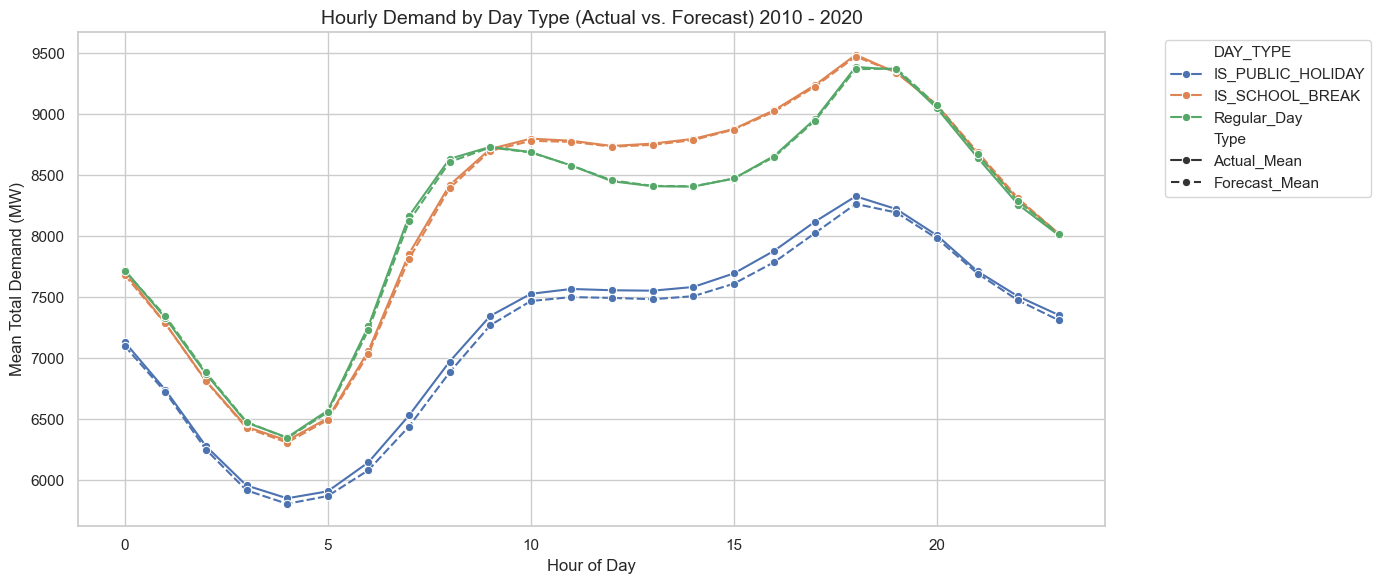

In [25]:
# Group by Day Type and Hour, then compute mean actual and forecasted demand
grouped = df_filtered.groupby(['DAY_TYPE', 'HOUR']).agg(
    Actual_Mean=('TOTALDEMAND', 'mean'),
    Forecast_Mean=('FORECASTING', 'mean')
).reset_index()

# Melt into long format for seaborn
melted = grouped.melt(id_vars=['DAY_TYPE', 'HOUR'], 
                      value_vars=['Actual_Mean', 'Forecast_Mean'], 
                      var_name='Type', value_name='Demand')

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=melted, x='HOUR', y='Demand', hue='DAY_TYPE', style='Type', marker='o')

plt.title("Hourly Demand by Day Type (Actual vs. Forecast) 2010 - 2020", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Mean Total Demand (MW)")
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


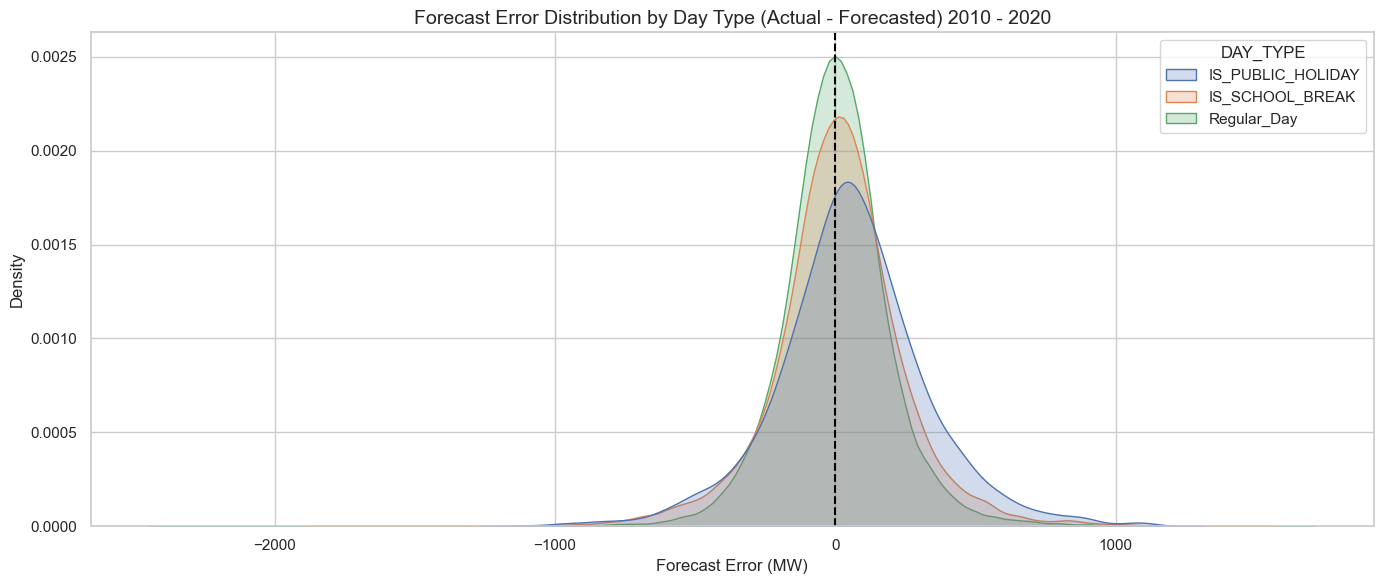

In [26]:
# Create a new column for forecast error
df_filtered['FORECAST_ERROR'] = df_filtered['TOTALDEMAND'] - df_filtered['FORECASTING']

# Plot KDE of forecast error by DAY_TYPE
plt.figure(figsize=(14, 6))
sns.kdeplot(data=df_filtered, x='FORECAST_ERROR', hue='DAY_TYPE', fill=True, common_norm=False)

plt.axvline(0, color='black', linestyle='--')
plt.title("Forecast Error Distribution by Day Type (Actual - Forecasted) 2010 - 2020", fontsize=14)
plt.xlabel("Forecast Error (MW)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()


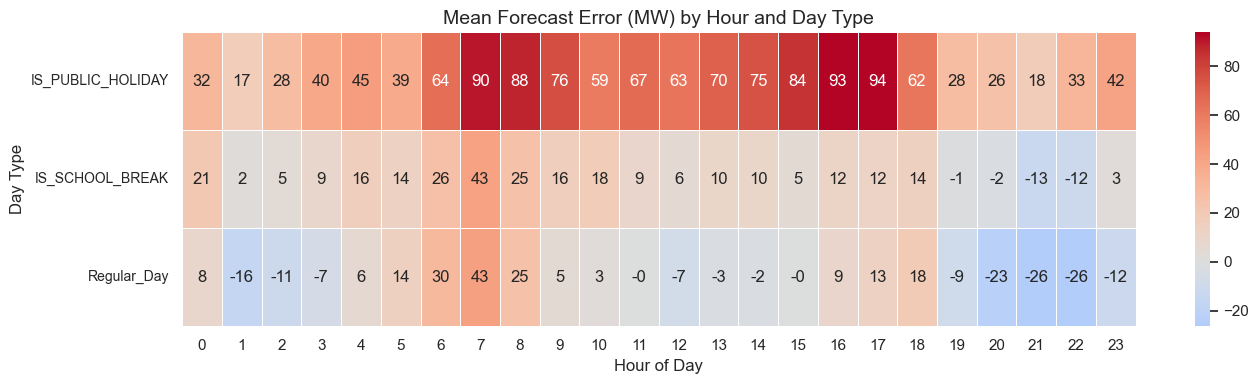

In [27]:
# Create pivot table: mean error for each Hour and Day Type
heatmap_data = df_filtered.groupby(['DAY_TYPE', 'HOUR'])['FORECAST_ERROR'].mean().unstack()

# Plot heatmap
plt.figure(figsize=(14, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="coolwarm", center=0, linewidths=0.5)

plt.title("Mean Forecast Error (MW) by Hour and Day Type", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Day Type")
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


# Modeling

In [28]:
# Safe copy for modeling
df_model = df_filtered.copy()

# One-hot encoding
#df_model = pd.get_dummies(df_model, columns=["DAY_TYPE", "SEASON"], drop_first=True)

### 1. Data Splitting

80% for Training (includes 20% Validation)


20% for Teston

In [29]:
X = df_model.drop(columns=(["TOTALDEMAND", "DATE", "FORECAST_ERROR", "MONTH", "FORECASTING", "DAY_TYPE", "SEASON"]))
y = df_model['TOTALDEMAND']

# Example: 80% train, then split train into training + validation
train_size = int(len(X) * 0.8)
val_size = int(train_size * 0.2)

X_train = X[:train_size - val_size]
y_train = y[:train_size - val_size]

X_valid = X[train_size - val_size:train_size]
y_valid = y[train_size - val_size:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

### 3. Prophet Model

In [30]:
y_train.reset_index()
y_valid.reset_index()
y_test.reset_index()

y_train = y_train.reset_index().rename(columns={'DATETIME': 'ds', 'TOTALDEMAND': 'y'})
y_valid = y_valid.reset_index().rename(columns={'DATETIME': 'ds', 'TOTALDEMAND': 'y'})
y_test = y_test.reset_index().rename(columns={'DATETIME': 'ds', 'TOTALDEMAND': 'y'})

y_train['is_weekend'] = y_train['ds'].dt.weekday >= 5
y_valid['is_weekend'] = y_valid['ds'].dt.weekday >= 5
y_test['is_weekend'] = y_test['ds'].dt.weekday >= 5
holidays_list = [(date, holiday) for date, holiday in sorted(nsw_holidays.items())]
holidays_df = pd.DataFrame(holidays_list, columns=['ds', 'holiday'])

holidays_df['lower_window'] = -1  
holidays_df['upper_window'] = 1   

model = Prophet(
    holidays=holidays_df,
    daily_seasonality=True,    
    weekly_seasonality=True,  
    yearly_seasonality=True,   
    seasonality_mode='multiplicative'
)

model.add_seasonality(
    name='monthly',
    period=720,               
    fourier_order=10          
)
model.add_regressor('is_weekend')
model.fit(y_train)

14:01:09 - cmdstanpy - INFO - Chain [1] start processing
14:05:19 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future_val = model.make_future_dataframe(periods=len(y_valid), freq='H')
future_val['is_weekend'] = future_val['ds'].dt.weekday >= 5
forecast_val = model.predict(future_val)
val_actuals = y_valid['y'].values
val_predictions = forecast_val['yhat'][-len(y_valid):].values

rmse_val = mean_squared_error(val_actuals, val_predictions)
mae_val = mean_absolute_error(val_actuals, val_predictions)
print(f"Validation RMSE: {rmse_val}, Validation MAE: {mae_val}")
future_test = model.make_future_dataframe(periods=len(y_test), freq='H')
future_test['is_weekend'] = future_test['ds'].dt.weekday >= 5
forecast_test = model.predict(future_test)

# Evaluate test performance using metrics like RMSE or MAE
test_actuals = y_test['y'].values
test_predictions = forecast_test['yhat'][-len(y_test):].values

rmse_test = mean_squared_error(test_actuals, test_predictions)
mae_test = mean_absolute_error(test_actuals, test_predictions)

print(f"Test RMSE: {rmse_test}, Test MAE: {mae_test}")

fig = model.plot_components(forecast_test)

Validation RMSE: 607060.5892661369, Validation MAE: 598.2459990791681


### 2. Model Preparation & Hyperparameter Tuning

In [33]:
# Scale inputs for neural network
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Define NN model function
def build_model(n_neurons=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(n_neurons, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

xgb_grid = {
    "n_estimators": [300, 500, 1000],
    "max_depth": [3, 4],
    "learning_rate": [0.01, 0.05, 0.001],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1]
}

rf_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5]
}

nn_grid = {
    "model__n_neurons": [32, 64],
    "model__dropout_rate": [0.1, 0.2],
    "model__learning_rate": [0.01, 0.001],
    "batch_size": [128],
    "epochs": [30]
}

# Define early stopping for NN
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Create model search objects
xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=xgb_grid,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_grid,
    n_iter=6,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

nn_search = RandomizedSearchCV(
    estimator=KerasRegressor(model=build_model, verbose=0),
    param_distributions=nn_grid,
    n_iter=5,
    cv=2,
    verbose=2
)

# Train models
print("Training XGBoost")
xgb_search.fit(X_train, y_train)

print("Training Random Forest")
rf_search.fit(X_train, y_train)

print("Training Neural Network")
nn_search.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), callbacks=[early_stop])

# Best models
xgb_model = xgb_search.best_estimator_
rf_model = rf_search.best_estimator_
nn_model = nn_search.best_estimator_

models = {
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Neural Network": nn_model
}

Training XGBoost
Fitting 3 folds for each of 10 candidates, totalling 30 fits


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py", line 407, in pandas_feature_info
    new_feature_types.append(_pandas_dtype_mapper[dtype.name])
                             ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'datetime64[ns]'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py", line 1222, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py", line 628, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py", line 1137, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 1614, in __init__
    self._init(
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 1678, in _init
    it.reraise()
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 572, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 553, in _handle_exception
    return fn()
           ^^^^
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 640, in <lambda>
    return self._handle_exception(lambda: int(self.next(input_data)), 0)
                                              ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py", line 1654, in next
    input_data(**self.kwargs)
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 629, in input_data
    self.proxy.set_info(
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 961, in set_info
    self.set_label(label)
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 1099, in set_label
    dispatch_meta_backend(self, label, "label", "float")
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py", line 1600, in dispatch_meta_backend
    _meta_from_pandas_df(data, name, dtype=dtype, handle=handle)
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py", line 654, in _meta_from_pandas_df
    data, _, _ = _transform_pandas_df(data, False, meta=name)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py", line 640, in _transform_pandas_df
    feature_names, feature_types = pandas_feature_info(
                                   ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py", line 409, in pandas_feature_info
    _invalid_dataframe_dtype(data)
  File "C:\Users\joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py", line 372, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:ds: datetime64[ns]


In [ ]:
results = [
    {
        "Model": "XGBoost",
        "Best Parameters": xgb_search.best_params_
    },
    {
        "Model": "Random Forest",
        "Best Parameters": rf_search.best_params_
    },
    {
        "Model": "Neural Network",
        "Best Parameters": nn_search.best_params_
    }
]

results_df = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)
display(results_df)

### 3. Model Prediction 

In [ ]:
# Predict
y_pred_xgb = xgb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_nn = nn_model.predict(X_test_scaled).flatten()

### 4. Model Evaluation Summary

In [ ]:
evaluation_results = [
    {
        "Model": "XGBoost",
        "R²": round(r2_score(y_test, y_pred_xgb), 2),
        "MAE": round(mean_absolute_error(y_test, y_pred_xgb), 2),
        "RMSE": round(mean_squared_error(y_test, y_pred_xgb, squared=False), 2)
    },
    {
        "Model": "Random Forest",
        "R²": round(r2_score(y_test, y_pred_rf), 2),
        "MAE": round(mean_absolute_error(y_test, y_pred_rf), 2),
        "RMSE": round(mean_squared_error(y_test, y_pred_rf, squared=False), 2)
    },
    {
        "Model": "Neural Network",
        "R²": round(r2_score(y_test, y_pred_nn), 2),
        "MAE": round(mean_absolute_error(y_test, y_pred_nn), 2),
        "RMSE": round(mean_squared_error(y_test, y_pred_nn, squared=False), 2)
    }
]

results_df = pd.DataFrame(evaluation_results)

# Show the result as a nice table
pd.set_option("display.max_colwidth", None)
display(results_df)

#### 5. Learning Curve Visualization 

In [ ]:
# DMatrix conversion
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

best_params = xgb_search.best_params_

# Set parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': best_params['learning_rate'],
    'max_depth': best_params['max_depth'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
    'seed': 42
}

# Create a dictionary to collect evals
evals_result = {}

# Train XGBoost model
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dvalid, 'valid')],
    early_stopping_rounds=30,  
    evals_result=evals_result,  
    verbose_eval=False
)

# XGBoost MAE data
train_mae_xgb = evals_result['train']['mae']
val_mae_xgb = evals_result['valid']['mae']

# Neural Network MAE data
best_nn_params = nn_search.best_params_

nn_m_model = build_model(
    n_neurons=best_nn_params['model__n_neurons'],
    dropout_rate=best_nn_params['model__dropout_rate'],
    learning_rate=best_nn_params['model__learning_rate']
)

history = nn_m_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=best_nn_params['epochs'],
    batch_size=best_nn_params['batch_size'],
    callbacks=[early_stop],
    verbose=0
)

train_mae_nn = history.history['mae']
val_mae_nn = history.history['val_mae']


# Random Forest

best_rf_params = rf_search.best_params_
# Define a range of trees to test (learning curve across n_estimators)
tree_counts = [10, 50, 100, 150, 200, 250]
train_mae_rf = []
val_mae_rf = []

# Train models with increasing number of trees
for n in tree_counts:
    rf = RandomForestRegressor(
        n_estimators=n,
        max_depth=best_rf_params['max_depth'],
        min_samples_split=best_rf_params['min_samples_split'],
        random_state=42
    )
    rf.fit(X_train, y_train)

    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_valid)

    train_mae_rf.append(mean_absolute_error(y_train, y_train_pred))
    val_mae_rf.append(mean_absolute_error(y_valid, y_val_pred))


# Plot subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 5), sharey=True)

# XGBoost Subplot
axes[0].plot(train_mae_xgb, label='Train MAE')
axes[0].plot(val_mae_xgb, label='Validation MAE')
axes[0].set_title("XGBoost MAE")
axes[0].set_xlabel("Boosting Rounds")
axes[0].set_ylabel("MAE")
axes[0].legend()

# Neural Network Subplot
axes[1].plot(train_mae_nn, label='Train MAE')
axes[1].plot(val_mae_nn, label='Validation MAE')
axes[1].set_title("Neural Network MAE")
axes[1].set_xlabel("Epochs")
axes[1].legend()

plt.tight_layout()
plt.show()

**The plots display the training and validation MAE (Mean Absolute Error) across iterations for the three models, These curves were generated during training using early stopping or fixed evaluation intervals and help visualize how each model learns over time.**

**Feature Importance**

In [ ]:
features = xgb_model.feature_names_in_

# Create aligned DataFrame
df_imp = pd.DataFrame({
    'Feature': features,
    'XGBoost': xgb_model.feature_importances_,
    'Random Forest': rf_model.feature_importances_
})

# Create two sorted versions of the DataFrame
df_xgb_sorted = df_imp.sort_values('XGBoost', ascending=True)
df_rf_sorted = df_imp.sort_values('Random Forest', ascending=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot XGBoost
axes[0].barh(df_xgb_sorted['Feature'], df_xgb_sorted['XGBoost'], color='#1f77b4')
axes[0].set_title("XGBoost Feature Importance", fontsize=14)
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Feature")
axes[0].grid(True, axis='x', linestyle='--', alpha=0.5)

# Plot Random Forest
axes[1].barh(df_rf_sorted['Feature'], df_rf_sorted['Random Forest'], color='#ff7f0e')
axes[1].set_title("Random Forest Feature Importance", fontsize=14)
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("Feature")
axes[1].grid(True, axis='x', linestyle='--', alpha=0.5)


plt.tight_layout()
plt.show()


In [ ]:
model_preds = [
    ("XGBoost", y_pred_xgb),
    ("Random Forest", y_pred_rf),
    ("Neural Network", y_pred_nn)
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, (model_name, y_pred) in enumerate(model_preds):
    ax = axes[i]
    ax.scatter(y_test[:200], y_pred[:200], c='red', alpha=0.6)
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
    ax.set_xlabel("Actual Demand")
    ax.set_ylabel("Predicted Demand" if i == 0 else "")
    ax.set_title(f"{model_name}", fontsize=18)
    ax.grid(True)

fig.suptitle("Actual vs Predicted Electricity Demand (First 100 Samples)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**This set of scatter plots visually compares Actual vs. Predicted Electricity Demand for the first 1000 samples using three machine learning models: XGBoost, Random Forest, and Neural Network.**

In [ ]:
df_plot = pd.DataFrame({
    'ACTUAL': y_test.values,
    'PRED_XGB': y_pred_xgb,
    'PRED_RF': y_pred_rf,
    'PRED_NN': y_pred_nn
})

fig, axes = plt.subplots(3, 1, figsize=(20, 18), sharey=True)

model_cols = [
    ("XGBoost", "PRED_XGB"),
    ("Random Forest", "PRED_RF"),
    ("Neural Network", "PRED_NN")
]

for i, (model_name, pred_col) in enumerate(model_cols):
    ax = axes[i]
    df_plot['ACTUAL'].iloc[:200].plot(ax=ax, label='Actual', color='steelblue', linewidth=2)
    df_plot[pred_col].iloc[:200].plot(ax=ax, label='Predicted', color='orangered', linestyle='--', marker='.')
    ax.set_title(f"{model_name}: Actual vs Predicted", fontsize=13)
    ax.set_xlabel("Sample Index")
    if i == 0:
        ax.set_ylabel("TOTALDEMAND (MW)")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.suptitle("Actual vs Predicted Electricity Demand (First 200 Samples)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**This plot displays the actual vs predicted electricity demand trends over time for two models (XGBoost, Random Forest, Neural Network) using the first 200 samples from the test dataset.**

In [ ]:
df_test = X_test.copy()
df_test['DATETIME'] = df_filtered.loc[X_test.index, 'DATE']
df_test['ACTUAL_TOTALDEMAND'] = y_test
df_test['PREDICTED_RF_TOTALDEMAND'] = y_pred_rf
df_test['PREDICTED_XGB_TOTALDEMAND'] = y_pred_xgb
df_test['PREDICTED_NN_TOTALDEMAND'] = y_pred_nn
df_test['FORECAST_TOTALDEMAND'] = df_filtered.loc[X_test.index, 'FORECASTING']

# Forecasting erros for all models including the actual forecasting
df_test["FORECAST_ERROR"] = abs(df_test["FORECAST_TOTALDEMAND"] - df_test["ACTUAL_TOTALDEMAND"])
df_test["XGB_ERROR"] = abs(df_test["PREDICTED_XGB_TOTALDEMAND"] - df_test["ACTUAL_TOTALDEMAND"])
df_test["RF_ERROR"] = abs(df_test["PREDICTED_RF_TOTALDEMAND"] - df_test["ACTUAL_TOTALDEMAND"])
df_test["NN_ERROR"] = abs(df_test["PREDICTED_NN_TOTALDEMAND"] - df_test["ACTUAL_TOTALDEMAND"])

df_monthly = df_test[[
    'ACTUAL_TOTALDEMAND',
    'PREDICTED_RF_TOTALDEMAND',
    'PREDICTED_XGB_TOTALDEMAND',
    'PREDICTED_NN_TOTALDEMAND',
    'FORECAST_TOTALDEMAND'
]].resample('W').mean().reset_index()

# Actual vs Predictions
plt.figure(figsize=(10, 4))
plt.plot(df_monthly['DATETIME'], df_monthly['ACTUAL_TOTALDEMAND'], label='Actual', linewidth=1)
plt.plot(df_monthly['DATETIME'], df_monthly['PREDICTED_RF_TOTALDEMAND'], label='Random Forest', linestyle='--')
plt.plot(df_monthly['DATETIME'], df_monthly['PREDICTED_XGB_TOTALDEMAND'], label='XGBoost', linestyle='--')
plt.plot(df_monthly['DATETIME'], df_monthly['PREDICTED_NN_TOTALDEMAND'], label='Neural Network', linestyle='--')
plt.title("Weekly Avg Electricity Demand: Actual vs Model Predictions (2010–2020)")
plt.xlabel("Date")
plt.ylabel("Demand (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Actual vs Forecast
plt.figure(figsize=(10, 4))
plt.plot(df_monthly['DATETIME'], df_monthly['ACTUAL_TOTALDEMAND'], label='Actual', linewidth=1)
plt.plot(df_monthly['DATETIME'], df_monthly['FORECAST_TOTALDEMAND'], label='Forecast', linestyle=':')
plt.title("Weekly Avg Electricity Demand: Actual vs Forecast (2010–2020)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Demand (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**This plot shows the model performance over time by comparing actual electricity demand with predictions from three models: Random Forest, XGBoost, and Neural Network using data the from test dataset**

In [ ]:
df_preds = pd.DataFrame({
    "Actual": y_test.values,
    "Forecasting": df_model.loc[y_test.index, "FORECASTING"].values,
    "XGBoost": y_pred_xgb,
    "Random Forest": y_pred_rf,
    "Neural Network": y_pred_nn
}, index=y_test.index)


# Step 2: Create actual_train with NaNs filled for missing times

actual_train = pd.concat([pd.concat([y_train, y_valid]), y_test])


fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 20), sharex=True)

# Forecasting vs Actual
axes[0].plot(actual_train.index, actual_train, label="Actual - Train", color="#95A3E9")
axes[0].plot(y_test.index, df_preds["Actual"], label="Actual - Test", color="skyblue")
axes[0].plot(y_test.index, df_preds["Forecasting"], label="Forecast", color="#FF9675")
axes[0].axvline(x=y_test.index[0], color='black', linestyle='--')
axes[0].set_title("Actual vs Forecasting")
axes[0].set_ylabel("Electricity Demand (MW)")
axes[0].legend()

# XGBoost vs Actual
axes[1].plot(actual_train.index, actual_train, label="Actual - Train", color="#95A3E9")
axes[1].plot(y_test.index, df_preds["Actual"], label="Actual - Test", color="skyblue")
axes[1].plot(df_preds.index, df_preds["XGBoost"], label="XGBoost Prediction", color="#FF9675")
axes[1].axvline(x=y_test.index[0], color='black', linestyle='--')
axes[1].set_title("XGBoost: Actual vs Prediction")
axes[1].set_ylabel("Electricity Demand (MW)")
axes[1].legend()

# Random Forest vs Actual
axes[2].plot(actual_train.index, actual_train, label="Actual - Train", color="#95A3E9")
axes[2].plot(y_test.index, df_preds["Actual"], label="Actual - Test", color="skyblue")
axes[2].plot(df_preds.index, df_preds["Random Forest"], label="RF Prediction", color="#FF9675")
axes[2].axvline(x=y_test.index[0], color='black', linestyle='--')
axes[2].set_title("Random Forest: Actual vs Prediction")
axes[2].set_ylabel("Electricity Demand (MW)")
axes[2].legend()

# Neural Network Prediction vs Actual
axes[3].plot(actual_train.index, actual_train, label="Actual - Train", color="#95A3E9")
axes[3].plot(y_test.index, df_preds["Actual"], label="Actual - Test", color="skyblue")
axes[3].plot(df_preds.index, df_preds["Neural Network"], label="NN Prediction", color="#FF9675")
axes[3].axvline(x=y_test.index[0], color='black', linestyle='--')
axes[3].set_title("Neural Network: Actual vs Prediction")
axes[3].set_xlabel("Datetime")
axes[3].set_ylabel("Electricity Demand (MW)")
axes[3].legend()

plt.tight_layout()
plt.show()
